In [1]:
import pandas as pd
import numpy as np

In [13]:
test = pd.read_csv('data/en/test.tsv', sep='\t')
test['set_type'] = 'test'
train = pd.read_csv('data/en/train.tsv', sep='\t')
train['set_type'] = 'train'
data = pd.concat((train, test))
data = data[['client_id', 'path', 'age', 'gender', 'sentence', 'set_type']]
data = data.dropna(subset=['age', 'gender'], how='any')
data = data[data.gender != 'other']
data = data[data.age != 'nineties']
data = data[data.age != 'eighties']
print(data['age'].value_counts())
# train.groupby(['age', 'gender']).apply(lambda x: x.sample(2000, replace=True))

twenties     121684
thirties      63770
fourties      54844
sixties       35270
fifties       23275
teens         21855
seventies      3759
Name: age, dtype: int64


In [1]:
from utils.data_preprocessor import DataPreprocessor
import pydub
import numpy as np
DP = DataPreprocessor(verbose=0)
DP.get_path(58)

# X = DP.cut_voice(X)

spec = DP.make_spectrogram(DP.get_path(58))
paded_spec = DP.pad_spec(spec, 256//2)

2022-02-08 01:30:49.495308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 01:30:49.495330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'data/en/clips/common_voice_en_19782154.mp3'

In [3]:
%%timeit
y = DP.load_audio_binary('data/en/clips/common_voice_en_19782154.mp3')

3.37 ms ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


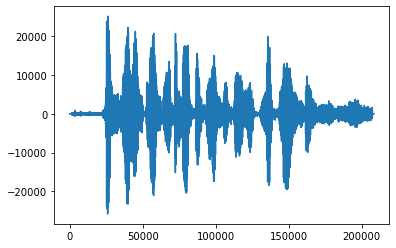

In [3]:
import matplotlib.pyplot as plt
plt.plot(y)

/run/media/stshalson/D246823C468220F9/Studia/SPEECH_AGE/utils/data_preprocessor.py:83: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(path)


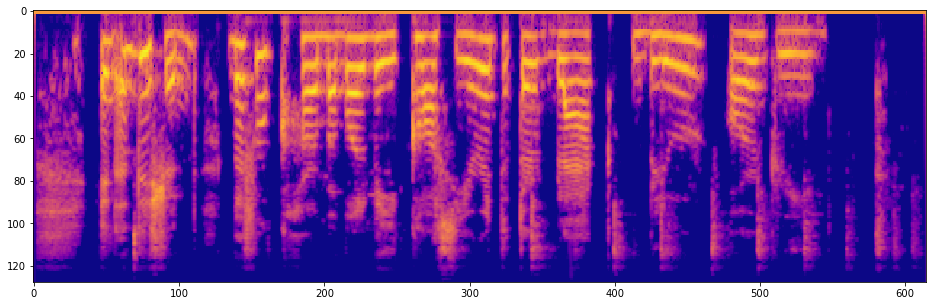

In [6]:
DP.show_spectra(60)

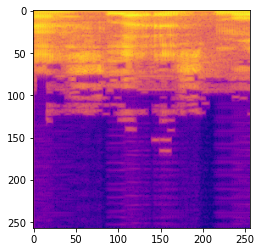

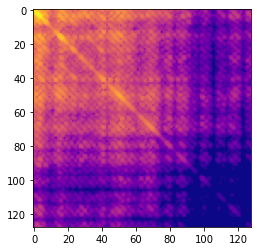

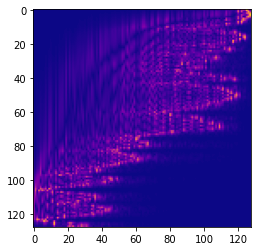

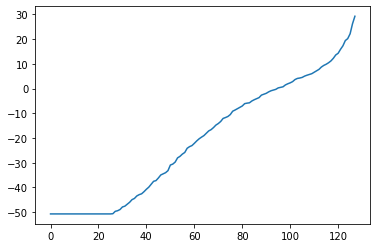

In [129]:
import numpy as np
import librosa

class EigenDecomposition:
    def __init__(self, fs=48000, nfft=512, freq_range=[200, 12200]):
        self.fs = fs
        self.nfft = nfft
        self.freq_range = [int(np.round(f / self.fs * self.nfft)) for f in freq_range]
        self.freq_bins = np.arange(self.freq_range[0], self.freq_range[1], dtype=int)
        
    def stft(self, X):
        S = librosa.core.stft(np.array(X), n_fft=self.nfft)
        return S

    def compute_correlation_matricesvec(self, X):
        # select frequency bins
        X = X[list(self.freq_bins), :].T
        # Compute PSD
        C_hat = np.matmul(X[..., None], np.conjugate(X[..., None, :]))
        # Average over time-frames
        C_hat = np.mean(C_hat, axis=0)
        return C_hat
    
    def subspace_decomposition(self, R):
        # eigenvalue decomposition
        # This method is specialized for Hermitian symmetric matrices,
        # which is the case since R is a covariance matrix
        w, v = np.linalg.eigh(R)
        return w, v

ED = EigenDecomposition()
S = ED.stft(X)[:, :256]
plt.imshow(librosa.power_to_db(np.abs(S)), cmap='plasma')
plt.show()

C_hat = ED.compute_correlation_matricesvec(S)
plt.imshow(librosa.power_to_db(np.abs(C_hat)), cmap='plasma')
plt.show()

w, v = ED.subspace_decomposition(C_hat)
plt.imshow(np.abs(v), cmap='plasma')
plt.show()
plt.plot(librosa.power_to_db(w))
plt.show()

In [130]:
v.shape

(128, 128)

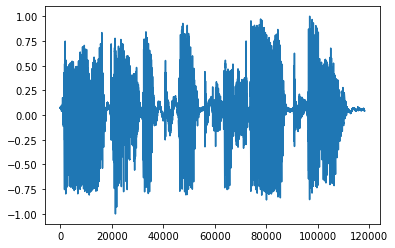

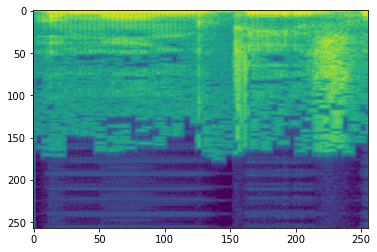

In [26]:
import matplotlib.pyplot as plt
plt.plot(X)
plt.show()
plt.imshow(librosa.power_to_db(np.abs(ED.stft(X)))[:, :256], aspect='auto')
plt.show()